# Captum

[Captum](captum.ai) is an explainability library from Facebook, providing a ton of methods for understanding the influence of particular features and neurons upon model predictions. Most of what follows is from their quickstart, with some additional comments.

In [ ]:
import numpy as np

import torch
import torch.nn as nn

from captum.attr import (
    IntegratedGradients
)

class ToyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(3, 3)
        self.relu = nn.ReLU()
        self.lin2 = nn.Linear(3, 2)

        # initialize weights and biases
        self.lin1.weight = nn.Parameter(torch.arange(-4.0, 5.0).view(3, 3))
        self.lin1.bias = nn.Parameter(torch.zeros(1,3))
        self.lin2.weight = nn.Parameter(torch.arange(-3.0, 3.0).view(2, 3))
        self.lin2.bias = nn.Parameter(torch.ones(1,2))

    def forward(self, input):
        return self.lin2(self.relu(self.lin1(input)))


model = ToyModel()
model.eval()

Matplotlib is building the font cache using fc-list. This may take a moment.


## What is integrated gradients?
### Motivation
It's a method for figuring out the importance of input features. It's based upon baselines: neutral inputs against which we measure our actual inputs to quantify the importance of different features.

The [original paper](https://arxiv.org/abs/1703.01365) sets out two axioms which they think interpretability methods should satisfy:

#### Sensitivity
If two examples result in different predictions and differ in a single feature, there should always be a non-zero attribution score for that feature. Simple gradient-based methods violate this because there could be non-linearities in activation functions which result in zero gradients.

#### Implementation invariance
If two networks always give the same output for the same inputs, attribution methods should also yield the same result, regardless of implementation details.

### How it works
* Take your baseline vector and the input vector
* Calculate the straightline path between the two
* Take the gradient at every point along this path
* Integrate those gradients

This seems nice in that the perturbations that result are going be less weird than random perturbations - intuitively more likely to be on the manifold.

In [4]:
torch.manual_seed(123)
np.random.seed(123)

In [5]:
input = torch.rand(2, 3)
baseline = torch.zeros(2, 3)

In [6]:
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(input, baseline, target=0, return_convergence_delta=True)

In [7]:
print(attributions)

tensor([[-0.5922, -1.5497, -1.0067],
        [ 0.0000, -0.2219, -5.1991]])


Ok, not very interesting because the network doesn't do anything and the inputs are meaningless.

# Titantic example
https://captum.ai/tutorials/Titanic_Basic_Interpret

In [9]:
!pip install scipy

     |████████████████████████████████| 27.7MB 1.5MB/s eta 0:00:01    |▊                               | 583kB 1.4MB/s eta 0:00:20     |█████████████████████████████   | 25.1MB 1.5MB/s eta 0:00:02


In [11]:
!pip install pandas

  Using cached https://files.pythonhosted.org/packages/73/75/42a0ec87e4f709d8d37d49f049b292578f14a4f1f6dc32a7f3c3c204e546/pandas-0.25.1-cp36-cp36m-macosx_10_9_x86_64.macosx_10_10_x86_64.whl
     |████████████████████████████████| 512kB 1.3MB/s eta 0:00:01


In [12]:
import numpy as np

import torch

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

In [13]:
titanic_data = pd.read_csv('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv')

#### Import and preprocess data

In [14]:
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['sex']),
                          pd.get_dummies(titanic_data['embarked'],prefix="embark"),
                          pd.get_dummies(titanic_data['pclass'],prefix="class")], axis=1)
titanic_data["age"] = titanic_data["age"].fillna(titanic_data["age"].mean())
titanic_data["fare"] = titanic_data["fare"].fillna(titanic_data["fare"].mean())
titanic_data = titanic_data.drop(['name','ticket','cabin','boat','body','home.dest','sex','embarked','pclass'], axis=1)

In [15]:
# Convert features and labels to numpy arrays.
labels = titanic_data["survived"].to_numpy()
titanic_data = titanic_data.drop(['survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

# Separate training and test sets using 
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

#### A toy model

In [16]:
class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(12,12)
        self.sig1 = nn.Sigmoid()
        self.l2 = nn.Linear(12, 8)
        self.sig2 = nn.Sigmoid()
        self.l3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.sig1(x)
        x = self.l2(x)
        x = self.sig2(x)
        return self.softmax(self.l3(x))

In [17]:
criterion = nn.CrossEntropyLoss()
n_epochs = 200

In [22]:
net = TitanicSimpleNNModel()
opt = torch.optim.Adam(net.parameters(), lr=0.1)

input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
label_tensor = torch.from_numpy(train_labels)

for epoch in range(n_epochs):
    output = net(input_tensor)
    loss = criterion(output, label_tensor)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 20 == 0:
        print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, n_epochs, loss.item()))

Epoch 1/200 => Loss: 0.73
Epoch 21/200 => Loss: 0.57
Epoch 41/200 => Loss: 0.53
Epoch 61/200 => Loss: 0.49
Epoch 81/200 => Loss: 0.49
Epoch 101/200 => Loss: 0.49
Epoch 121/200 => Loss: 0.48
Epoch 141/200 => Loss: 0.47
Epoch 161/200 => Loss: 0.47
Epoch 181/200 => Loss: 0.47


In [23]:
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Train Accuracy: 0.8395196506550219
Test Accuracy: 0.7913486005089059


## Feature importances

In [24]:
ig = IntegratedGradients(net)

In [26]:
test_input_tensor.requires_grad_() # we will need these for IG
attr, delta = ig.attribute(test_input_tensor, target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

Average Feature Importances
age :  -0.903
sibsp :  -0.084
parch :  0.003
fare :  0.133
female :  0.236
male :  -0.121
embark_C :  0.038
embark_Q :  -0.008
embark_S :  0.064
class_1 :  0.069
class_2 :  0.061
class_3 :  -0.179


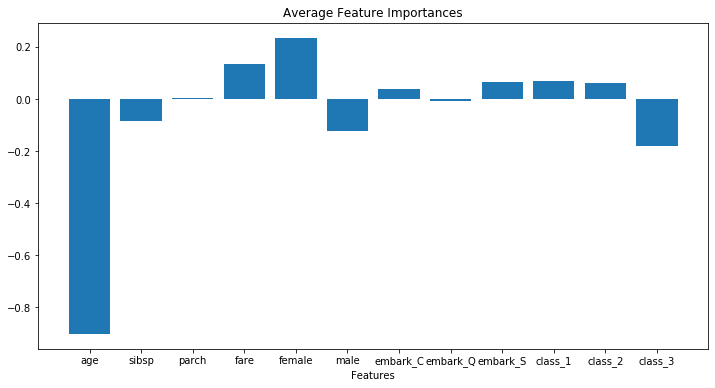

In [27]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

Means are not the whole story - we can look at attributions for different levels of the input feature:

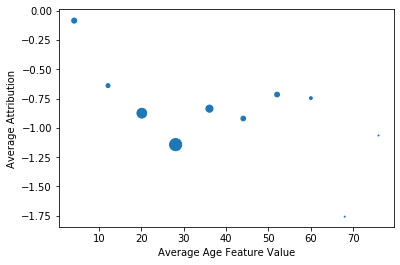

In [29]:
bin_means, bin_edges, _ = stats.binned_statistic(test_features[:,0], attr[:,0], statistic='mean', bins=10)
bin_count, _, _ = stats.binned_statistic(test_features[:,0], attr[:,0], statistic='count', bins=10)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.scatter(bin_centers, bin_means, s=bin_count)
plt.xlabel("Average Age Feature Value");
plt.ylabel("Average Attribution");

So we can see that being aged around 30 is particularly bad for your survival here! This kind of breakdown seems very important for neural networks, because we're often using them because we think some non-linearity exists in the data.

## Neuron importances

I still haven't really understood why people think that it's important to understand the function of individual neurons, especially since this DeepMind paper showed that [neurons which are intepretable are not necessarily important](https://deepmind.com/blog/article/understanding-deep-learning-through-neuron-deletion). 

Anyhow - they use `LayerConductances` to examine neuron importance ([paper](https://arxiv.org/abs/1805.12233)). This is intuited as the 'flow of integrated gradients via a particular neuron'. They achieve this by using the chain rule on IG.

In [31]:
cond = LayerConductance(net, net.sig1)

Average Neuron Importances
0 :  0.000
1 :  0.000
2 :  0.012
3 :  0.006
4 :  0.001
5 :  -0.290
6 :  -0.338
7 :  -0.002
8 :  -0.023
9 :  0.003
10 :  -0.004
11 :  -0.000


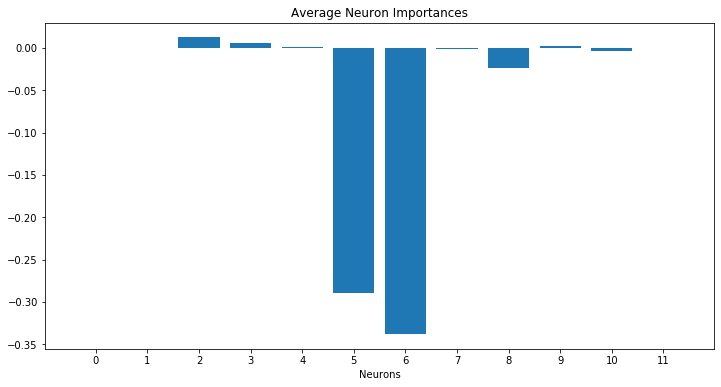

In [32]:
cond_vals = cond.attribute(test_input_tensor,target=1)
cond_vals = cond_vals.detach().numpy()
visualize_importances(range(12),np.mean(cond_vals, axis=0),title="Average Neuron Importances", axis_title="Neurons")

Some useless neurons

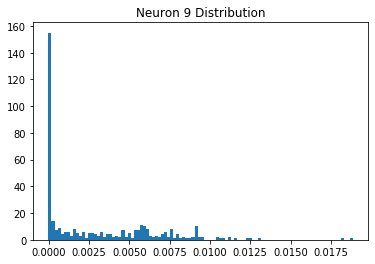

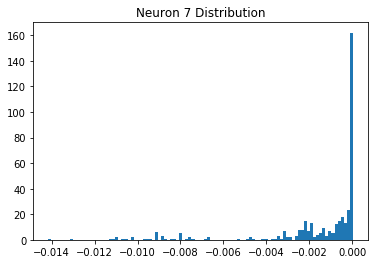

In [33]:
plt.hist(cond_vals[:,9], 100);
plt.title("Neuron 9 Distribution")
plt.figure()
plt.hist(cond_vals[:,7], 100);
plt.title("Neuron 7 Distribution");

Some interesting ones

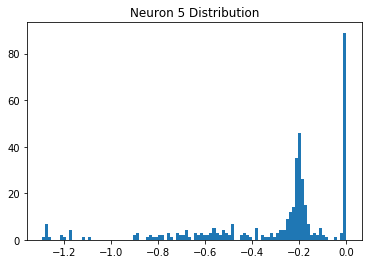

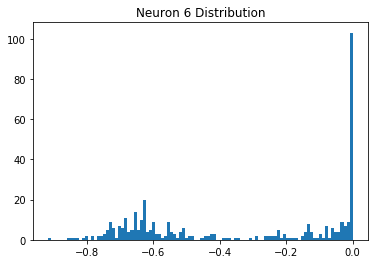

In [36]:
plt.hist(cond_vals[:,5], 100);
plt.title("Neuron 5 Distribution")
plt.figure()
plt.hist(cond_vals[:,6], 100);
plt.title("Neuron 6 Distribution");

### What is each each neuron interested in?
They define `NeuronConductance`, which allows us to carve up the contribution of each neuron by each feature.

In [38]:
neuron_cond = NeuronConductance(net, net.sig1)

In [39]:
neuron_cond_vals_6 = neuron_cond.attribute(test_input_tensor, neuron_index=6, target=1)

Average Feature Importances for Neuron 6
age :  -0.503
sibsp :  -0.034
parch :  0.013
fare :  -0.046
female :  -0.002
male :  0.105
embark_C :  -0.006
embark_Q :  -0.002
embark_S :  0.071
class_1 :  0.004
class_2 :  0.015
class_3 :  0.013


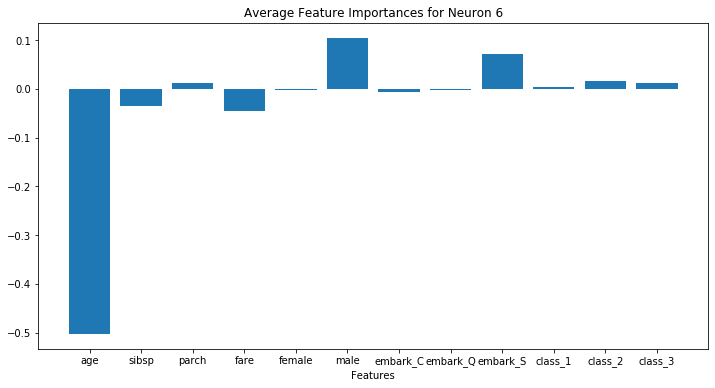

In [40]:
visualize_importances(feature_names, neuron_cond_vals_6.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 6")